교재 5.6 인포턴스 샘플링을 통한 오프-폴리시 예측을 증가적으로 구현하는 코드입니다.

In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
#from lib.envs.blackjack import BlackjackEnv
#from lib import plotting
from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

행동 정책으로 사용할, 임의로 행동을 선택하는 정책이다. 모든 행동의 확률이 `1 / nA`로 같은 배열을 반환한다.

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

대상 정책으로 사용할, 탐욕스러운 그리디 정책이다. 수확을 최대로 만드는 행동만 선택하도록 확률 배열을 만든다. `np.zeros_like()`는 첫번째 아규먼트와 동일한 차원을 (여기서는 행동 가짓수, 2) 가지고 배열을 만들고 0으로 채운다. 기본값 `dtype=float`는 생략해도 된다.

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

# 1

상태((현재 선수가 가진 카드의 합, 딜러가 공개한 카드, 선수의 유저블 에이스 보유 여부) 튜플)를 크기가 행동 가짓수인 행렬로 대응한다. 즉, 상태와 행동 조합으로 접근하는 다차원 배열이다. 이 코드 대신 NumPy로 다차원 배열을 만들길 권한다.

# 2

교재 상자 안에 있는 오프-폴리시 몬테카를로 예측를 구현합니다. 교재와 비교하여 제일 마지막 두 문장의 순서가 바뀌었지만 의미는 동일합니다. `[::-1]`는 리스트를 역순으로 만듭니다. `[시작:끝:증가분]`에서 시작과 끝을 생략하면 전체 리스트의 시작과 끝을 사용하고, 기본값이 1인 증가분에 -1을 사용하면 역순으로 진행합니다. `reversed()`도 리스트를 역순으로 만듭니다. 교재에서 π(At|St)는 (if 조건을 충족했다면) 1이므로 아래 코드에서 `1.`을 사용합니다.

In [5]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Lambda discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    ###< 1 >###
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # The cumulative denominator of the weighted importance sampling formula
    # (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
        
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            # Sample an action from our policy
            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        
        ###< 2 >###
        # Sum of discounted returns
        G = 0.0
        # The importance sampling ratio (the weights of the returns)
        W = 1.0
        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]
            # Update the total reward since step t
            G = discount_factor * G + reward
            # Update weighted importance sampling formula denominator
            C[state][action] += W
            # Update the action-value function using the incremental update formula (5.7)
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            # If the action taken by the behavior policy is not the action 
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]
        
    return Q, target_policy

In [6]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

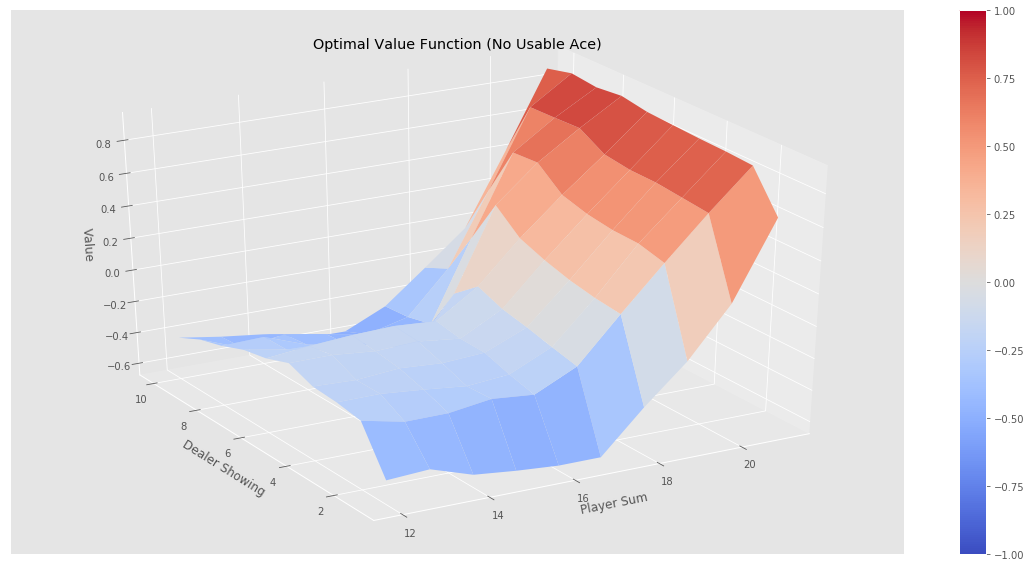

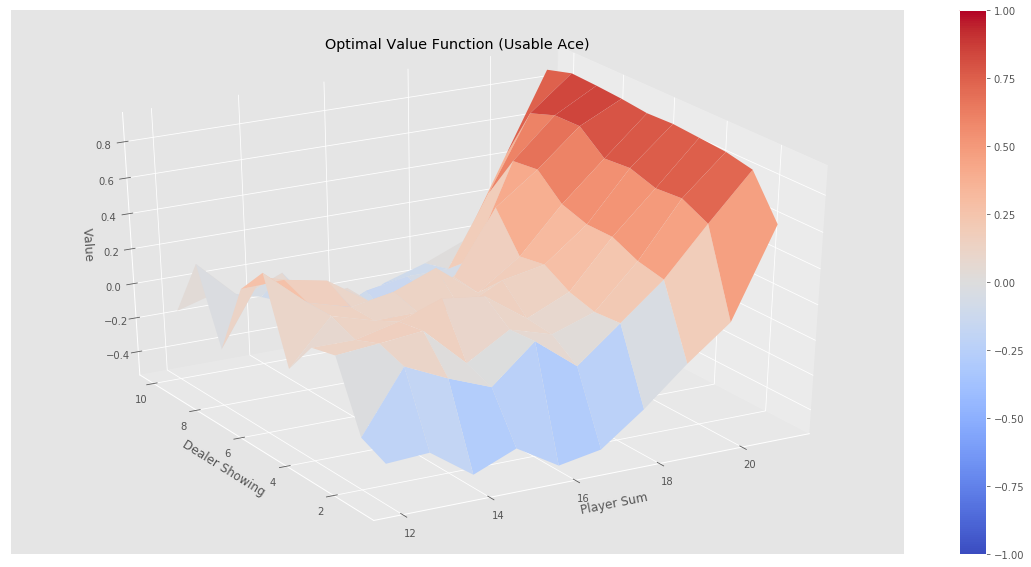

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")